<a href="https://colab.research.google.com/github/tobonjose9/Tarea-1/blob/main/Tarea1/src/Tarea1EST3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarea 1: Exploración de datos, PCA y regresión básica#

Fecha entrega: 03/26/2025 11:55 PM

Objetivo: Utilizar conceptos estadísticos para entender la relación entre las variables de una base de datos. Adicionalmente, utilizar python como herramienta de exploración de datos y validación de hipótesis.

Entrega: Crear un repositorio en su github personal. Dentro del proyecto debe existir una carpeta llamada tarea 1, dentro debe tener una carpeta doc con este documento incluyendo todas las respuestas y los gráficos. Adicionalmente, debe existir una carpeta src con el código del notebook utilizado. Debe adicionar la cuenta jdramirez como colaborador del proyecto y enviar un email antes de q se termine el dia indicando el commit desea le sea calificado.


#1. Utilizas el set de datos para calcular paso por paso (mostrar procedimiento y fórmulas ):

1.1 ¿Cuál es la media, mediana y desviación estándar?, y la moda y los
valores repeticiones de la moda para los datos categóricos.

1.2. Dibujar un boxplot a mano. Utilizando los datos de la tabla 1 y las
siguientes proporciones.

1.3. Cual es la covarianza entre las 2 variables X1, X2

1.4. Cuál es la correlación entre la variable x1 y x2 (Calcularla a mano).

### NOTA: Los puntos del taller 1.1 al 1.4 se resuelven en el excel Punto1Taller1 adjunto en el git.

##1.5. Explica la relación entre covarianza y correlación.

Tanto la covarianza como la correlación son medidas estadísticas que evalúan la relación lineal entre dos variables dentro de un conjunto de datos. La covarianza indica la dirección (positiva o negativa) de esta relación, así como su fuerza, pero no proporciona una medida estandarizada, lo que dificulta la comparación entre diferentes pares de variables. Por otro lado, la correlación estandariza esta medida, ofreciendo un valor entre -1 y +1, lo que permite una comparación directa de la fuerza y dirección de la relación lineal, sin verse afectada por las diferencias en las unidades de medida de las variables. En resumen, la covarianza establece la base para entender la relación entre variables, mientras que la correlación proporciona una medida estandarizada y comparable de esta relación.

##1.6. Calcule el resultado del algoritmo K-means sobre este set de datos a mano como lo hicimos en excel o con python sin utilizar librerías. Vamos a crear 4 grupos, es decir, k=4 ( clusters).


In [93]:
import pandas as pd
import numpy as np
import random
from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from collections import Counter

def cargar_datos(ruta_excel: str) -> pd.DataFrame:
    return pd.read_excel(ruta_excel)

def normalizar_datos(datos: np.ndarray) -> np.ndarray:
    min_valores = np.min(datos, axis=0)
    max_valores = np.max(datos, axis=0)
    return (datos - min_valores) / np.where(max_valores - min_valores == 0, 1, max_valores - min_valores)

def calcular_distancia_euclidiana(punto1: np.ndarray, punto2: np.ndarray) -> float:
    return np.linalg.norm(punto1 - punto2)

def inicializar_centroides(puntos: np.ndarray, num_clusters: int) -> np.ndarray:
    centroides = [puntos[random.randint(0, len(puntos) - 1)]]
    for _ in range(1, num_clusters):
        distancias = np.array([min([calcular_distancia_euclidiana(p, c) for c in centroides]) for p in puntos])
        probabilidades = distancias / np.sum(distancias)
        centroides.append(puntos[np.random.choice(len(puntos), p=probabilidades)])
    return np.array(centroides)

def asignar_puntos_a_clusters(puntos: np.ndarray, centroides: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    distancias = np.linalg.norm(puntos[:, np.newaxis] - centroides, axis=2)
    return np.argmin(distancias, axis=1), distancias

def actualizar_centroides(puntos: np.ndarray, asignaciones: np.ndarray, num_clusters: int) -> np.ndarray:
    return np.array([puntos[asignaciones == i].mean(axis=0) if np.any(asignaciones == i) else random.choice(puntos) for i in range(num_clusters)])

def guardar_resultados(dataframe: pd.DataFrame, centroides: np.ndarray, distancias: np.ndarray, grupos: np.ndarray, iteracion: int, nombre_archivo: str = 'Rkmeans.xlsx'):
    df_resultado = dataframe.copy()
    for i in range(len(centroides)):
        df_resultado[f'distancia_centro_{i}'] = distancias[:, i]
    df_resultado['grupo'] = grupos
    df_centroides = pd.DataFrame(centroides, columns=dataframe.select_dtypes(include='number').columns)

    libro = load_workbook(nombre_archivo) if iteracion > 0 else Workbook()
    hoja = libro.active
    hoja.append([f"Iteración: {iteracion}"])
    for fila in dataframe_to_rows(df_resultado, index=False, header=True):
        hoja.append(fila)
    hoja.append([f"Centros de la Iteración: {iteracion}"])
    for fila in dataframe_to_rows(df_centroides, index=False, header=True):
        hoja.append(fila)
    libro.save(nombre_archivo)

def ejecutar_kmeans(puntos: np.ndarray, dataframe: pd.DataFrame, num_clusters: int, max_iter: int = 100, archivo_resultado: str = 'Rkmeans.xlsx'):
    columnas_numericas = dataframe.select_dtypes(include='number').columns
    centroides = inicializar_centroides(puntos, num_clusters)

    for iteracion in range(max_iter):
        grupos, distancias = asignar_puntos_a_clusters(puntos, centroides)
        nuevos_centroides = actualizar_centroides(puntos, grupos, num_clusters)
        guardar_resultados(dataframe, centroides, distancias, grupos, iteracion, archivo_resultado)
        if np.linalg.norm(nuevos_centroides - centroides) < 1e-6:
            print(f"Convergencia alcanzada en la iteración {iteracion}")
            break
        centroides = nuevos_centroides

    pd.DataFrame(centroides, columns=columnas_numericas).to_excel('CFkmeans.xlsx', index=False)

def predecir_clusters(datos_prueba: np.ndarray, centroides: np.ndarray, etiquetas: list) -> list:
    distancias = np.linalg.norm(datos_prueba[:, np.newaxis] - centroides, axis=2)
    return [etiquetas[idx] for idx in np.argmin(distancias, axis=1)]

In [94]:
if __name__ == "__main__":
    ARCHIVO_ENTRADA = "train.xlsx"
    NUM_CLUSTERS = 4

    df_train = cargar_datos(ARCHIVO_ENTRADA)
    datos_numericos = normalizar_datos(df_train.select_dtypes(include='number').values)
    ejecutar_kmeans(datos_numericos, df_train, NUM_CLUSTERS)

    df_centroides = cargar_datos("CFkmeans.xlsx")
    df_test = cargar_datos("test.xlsx")
    centroides_norm = normalizar_datos(df_centroides.values)
    columnas_centroides = df_centroides.columns.intersection(df_test.columns)
    datos_test_norm = normalizar_datos(df_test[columnas_centroides].values)
    etiquetas = df_train['City'].values

    df_test['etiqueta'] = predecir_clusters(datos_test_norm, centroides_norm, etiquetas)
    df_test['ID'] = df_test['City']

    df_salida = df_test[['ID', 'etiqueta']]
    df_salida.to_csv('kmeans_JoseTobon.csv', index=False, encoding="utf-8-sig")
    print("Proceso finalizado. Archivo 'kmeans_JoseTobon.csv' generado exitosamente.")
    files.download("kmeans_JoseTobon.csv")

Convergencia alcanzada en la iteración 5
Proceso finalizado. Archivo 'kmeans_JoseTobon.csv' generado exitosamente.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##1.7. Calcula el resultado de un dendrograma utilizando la distancia máxima (complete) en python.

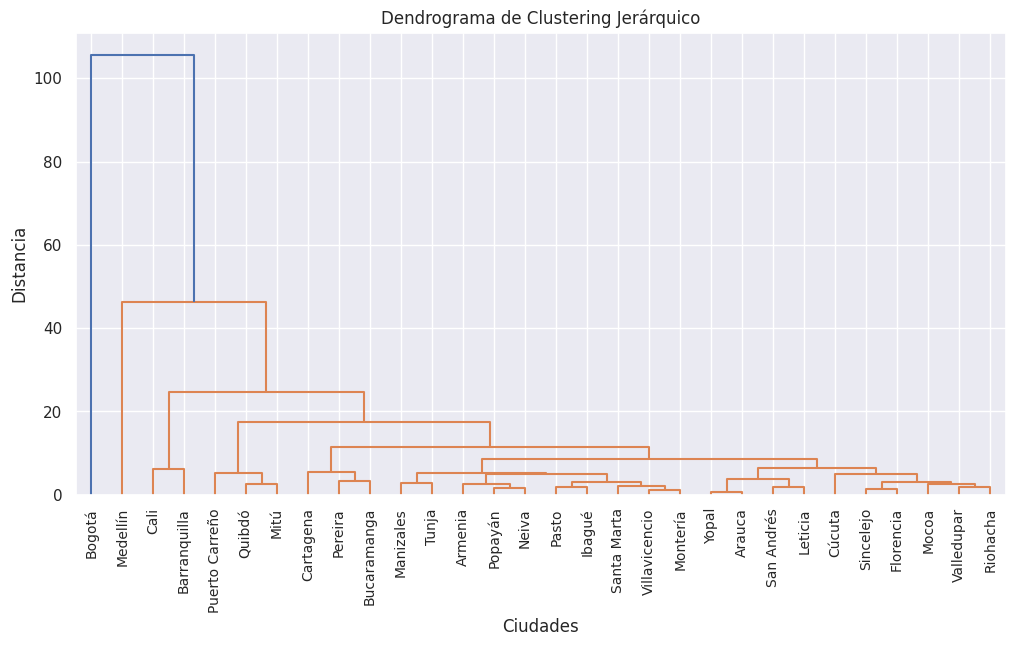

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

def cargar_datos(nombre_archivo: str) -> pd.DataFrame:
    """Carga los datos desde un archivo Excel y elimina columnas no numéricas."""
    df = pd.read_excel(nombre_archivo)
    nombres_ciudades = df["City"].values
    datos_numericos = df.drop(columns=['City', 'Initial Label', 'Label'])
    return nombres_ciudades, datos_numericos

def generar_dendrograma(datos: pd.DataFrame, etiquetas: list, metodo: str = 'complete'):
    """Genera y muestra un dendrograma basado en clustering jerárquico."""
    matriz_vinculacion = linkage(datos, method=metodo)
    plt.figure(figsize=(12, 6))
    dendrogram(matriz_vinculacion, labels=etiquetas, leaf_rotation=90, leaf_font_size=10)
    plt.title("Dendrograma de Clustering Jerárquico")
    plt.xlabel("Ciudades")
    plt.ylabel("Distancia")
    plt.show()

if __name__ == "__main__":
    ARCHIVO_DATOS = "Datos.xlsx"
    nombres_ciudades, datos_numericos = cargar_datos(ARCHIVO_DATOS)
    generar_dendrograma(datos_numericos, nombres_ciudades)


#2. PCA.
Utilizar los datos de la tabla 1, para calcular PCA y reducir la dimensionalidad de 2 dimensiones a 1. Para este ejercicio se debe utilizar las variables GDP (USD Billion) y Population (Millions) para crear un vector con una sola dimensión.

###2.1. Cual es la matriz de covarianza
###2.2. Cuales son los eigenvalues
###2.3. Cuál es la varianza explicada por el eigenvalue.
###2.4. Cual es el valor del eigenvector
###2.5. Cuál es la matriz proyectada.
###2.6. Cual es el error o diferencia entre la matriz proyectada
###2.7. Pintar todas las ciudades en 1 dimensión.
###2.8. Utilizar python para pintar todas las ciudades en 2 dimensiones,


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Cargar los datos de entrenamiento
df_entrenamiento = pd.read_excel("train.xlsx")
df_prueba = pd.read_excel("test.xlsx")
# Seleccionar variables para PCA
variables_pca = ['GDP', 'Population']

In [58]:
# Normalización con los datos de entrenamiento
scaler = StandardScaler()
# Replace df_train with df_entrenamiento
train_scaled = scaler.fit_transform(df_entrenamiento[variables_pca])
# Replace df_test with df_prueba
test_scaled = scaler.transform(df_prueba[variables_pca])
print("Datos normalizados (entrenamiento):")
print(pd.DataFrame(train_scaled, columns=variables_pca).head())

print("\nDatos normalizados (prueba):")
print(pd.DataFrame(test_scaled, columns=variables_pca).head())

Datos normalizados (entrenamiento):
        GDP  Population
0 -0.395990   -0.382077
1 -0.439597   -0.478670
2 -0.029694    0.088007
3 -0.217203   -0.266166
4 -0.387269   -0.362759

Datos normalizados (prueba):
        GDP  Population
0 -0.334941   -0.253287
1 -0.452679   -0.549504
2 -0.461400   -0.568823
3 -0.265170   -0.085860
4 -0.348023   -0.285485


In [60]:
# Calcular la matriz de covarianza
matriz_covarianza = np.cov(train_scaled, rowvar=False)
print("Matriz de covarianza:\n", matriz_covarianza)


Matriz de covarianza:
 [[1.05       1.04139549]
 [1.04139549 1.05      ]]


In [78]:
# Obtener eigenvalores y eigenvectores
valores_propios, vectores_propios = np.linalg.eig(matriz_covarianza)
print("\nEigenvalores:")
print(valores_propios)
print("\nEigenvectores:")
print(vectores_propios)



Eigenvalores:
[0.00860451 2.09139549]

Eigenvectores:
[[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]


In [63]:
# Calcular varianza explicada
varianza_total = np.sum(valores_propios)
varianza_explicada = valores_propios / varianza_total
print("Varianza explicada por cada componente:\n", varianza_explicada)

Varianza explicada por cada componente:
 [0.00409738 0.99590262]


In [69]:
# Aplicar PCA usando solo los datos de entrenamiento
pca = PCA(n_components=1)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)
# Agregar la nueva dimensión a los DataFrames
df_entrenamiento['PCA_1D'] = train_pca  # Using df_entrenamiento
df_prueba['PCA_1D'] = test_pca
# Mostrar los primeros valores de PCA
print("\nPCA reducido a 1D (entrenamiento):")
print(df_entrenamiento[['PCA_1D']].head())  # Using df_entrenamiento

print("\nPCA reducido a 1D (prueba):")
print(df_prueba[['PCA_1D']].head()) # Using df_prueba


PCA reducido a 1D (entrenamiento):
     PCA_1D
0 -0.550177
1 -0.649313
2  0.041233
3 -0.341793
4 -0.530350

PCA reducido a 1D (prueba):
     PCA_1D
0 -0.415940
1 -0.708651
2 -0.728478
3 -0.248216
4 -0.447958


In [79]:
# Reconstrucción de la matriz proyectada
matriz_proyectada = np.dot(train_pca, pca.components_)
print("\nMatriz proyectada:")
print(matriz_proyectada[:5])



Matriz proyectada:
[[-0.38903374 -0.38903374]
 [-0.45913336 -0.45913336]
 [ 0.02915621  0.02915621]
 [-0.24168449 -0.24168449]
 [-0.37501382 -0.37501382]]


In [80]:
# Calcular el error entre la matriz original y la proyectada
error_proyeccion = np.linalg.norm(train_scaled - matriz_proyectada)
print("\nError de proyección:", error_proyeccion)



Error de proyección: 0.41483744826087077


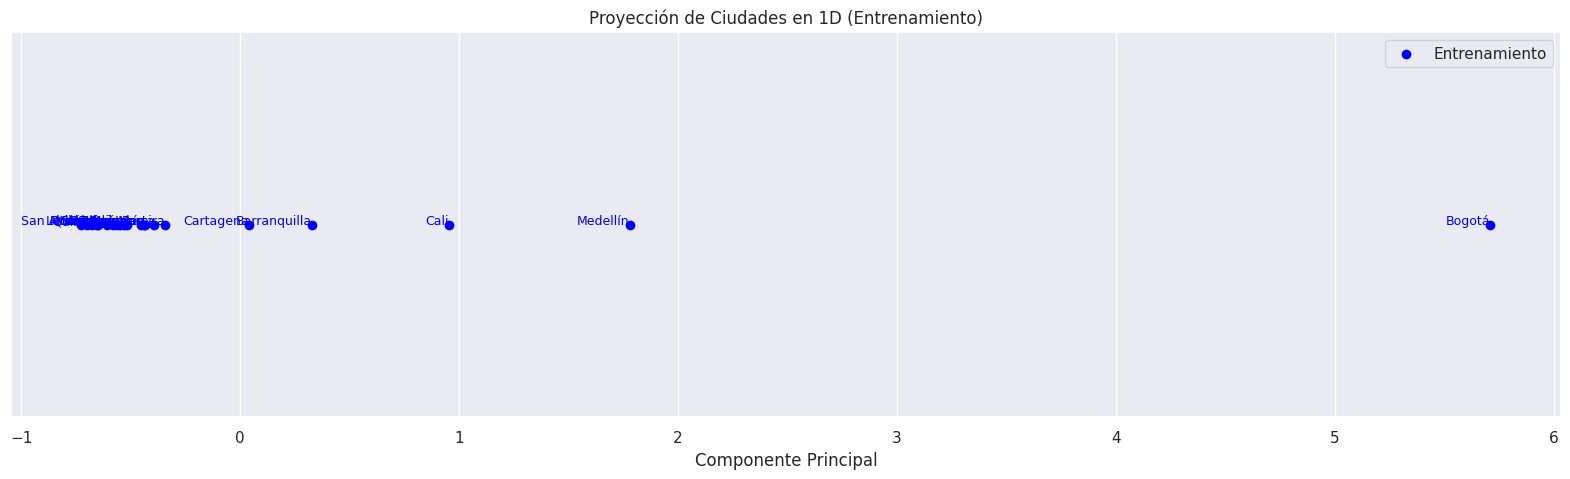

In [73]:
# Gráfico de proyección en 1D para entrenamiento
ciudades_entrenamiento = df_entrenamiento['City'].values
ciudades_prueba = df_prueba['City'].values

plt.figure(figsize=(20, 5))
plt.scatter(train_pca[:, 0], np.zeros_like(train_pca[:, 0]), c='blue', marker='o', label="Entrenamiento")

for i, ciudad in enumerate(ciudades_entrenamiento):
    plt.text(train_pca[i, 0], 0, ciudad, fontsize=9, ha='right', color='blue')

plt.title('Proyección de Ciudades en 1D (Entrenamiento)')
plt.xlabel('Componente Principal')
plt.yticks([])
plt.grid(True)
plt.legend()
plt.show()

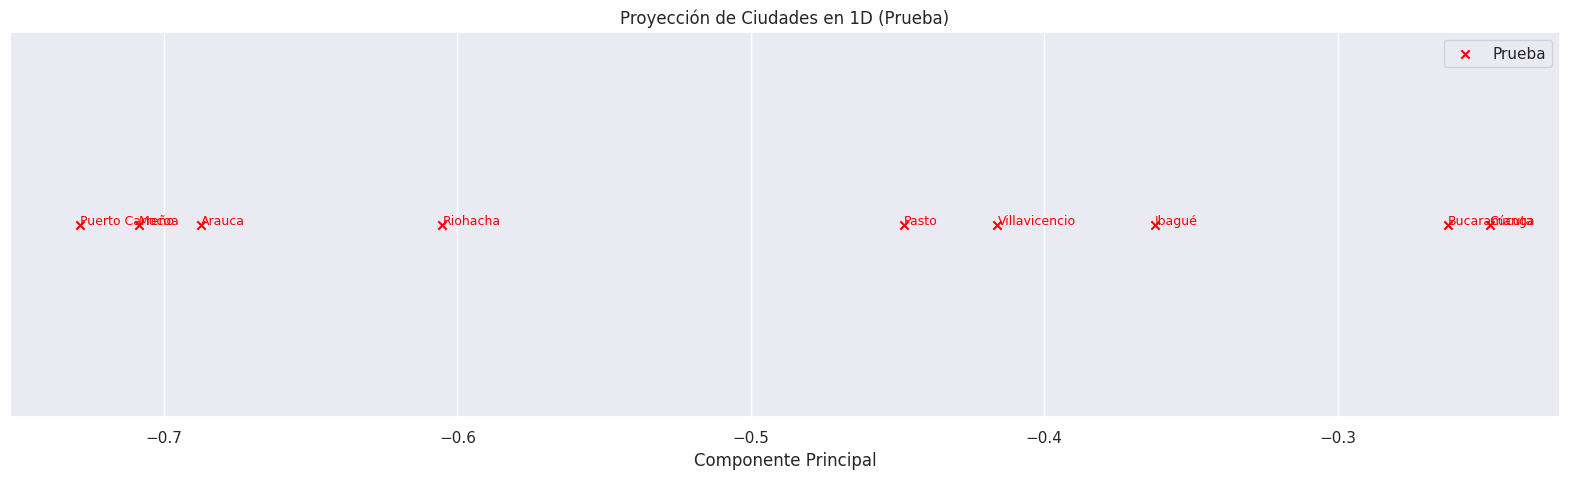

In [74]:
# Gráfico de proyección en 1D para prueba
plt.figure(figsize=(20, 5))
plt.scatter(test_pca[:, 0], np.zeros_like(test_pca[:, 0]), c='red', marker='x', label="Prueba")

for i, ciudad in enumerate(ciudades_prueba):
    plt.text(test_pca[i, 0], 0, ciudad, fontsize=9, ha='left', color='red')

plt.title('Proyección de Ciudades en 1D (Prueba)')
plt.xlabel('Componente Principal')
plt.yticks([])
plt.grid(True)
plt.legend()
plt.show()

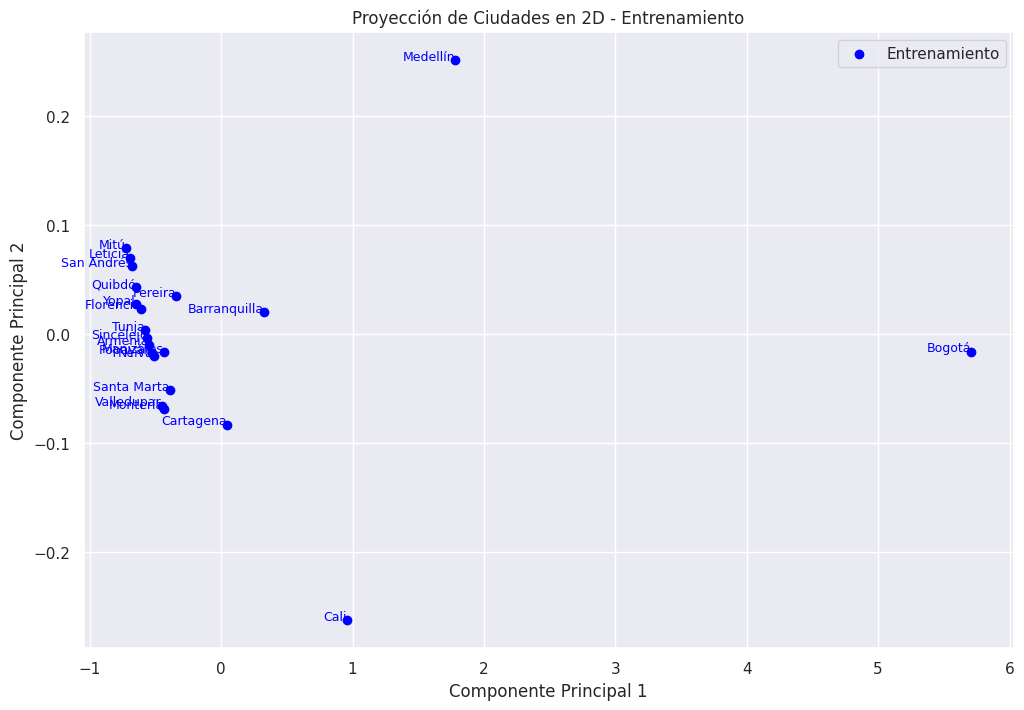

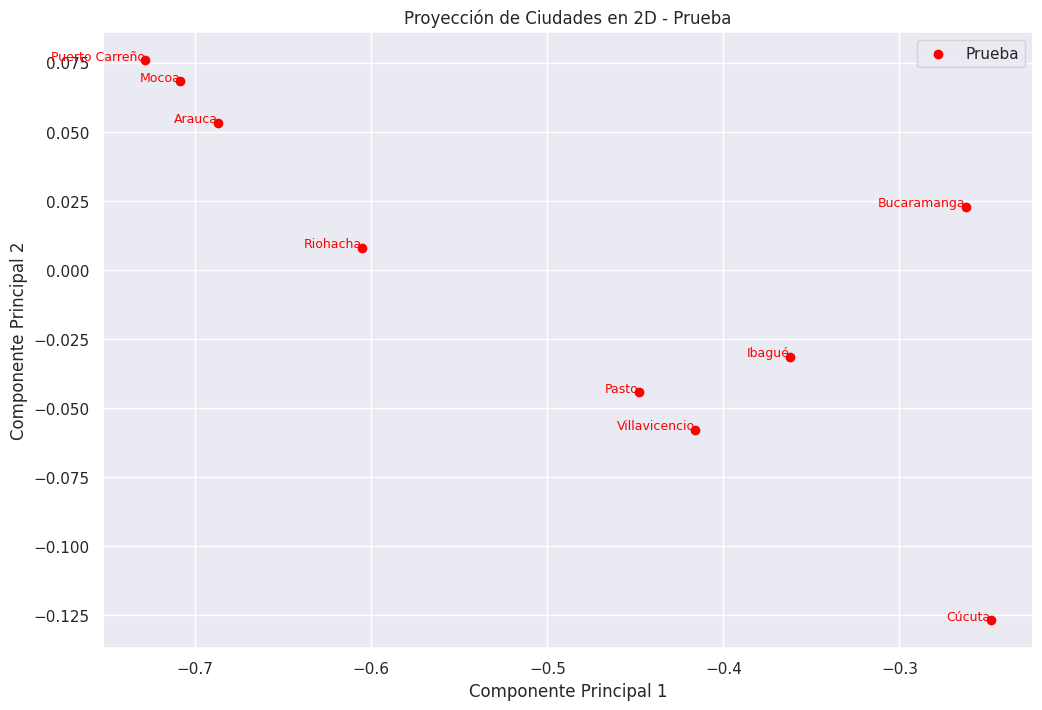

In [77]:
# Aplicar PCA con sklearn para reducir a 2 dimensiones
pca_2d = PCA(n_components=2)
train_pca_2d = pca_2d.fit_transform(train_scaled)
test_pca_2d = pca_2d.transform(test_scaled)

# Gráfico de proyección en 2D para entrenamiento
plt.figure(figsize=(12, 8))
plt.scatter(train_pca_2d[:, 0], train_pca_2d[:, 1], c='blue', marker='o', label="Entrenamiento")

for i, ciudad in enumerate(ciudades_entrenamiento):
    plt.text(train_pca_2d[i, 0], train_pca_2d[i, 1], ciudad, fontsize=9, ha='right', color='blue')

plt.title('Proyección de Ciudades en 2D - Entrenamiento')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.legend()
plt.show()

# Gráfico de proyección en 2D para prueba
plt.figure(figsize=(12, 8))
plt.scatter(test_pca_2d[:, 0], test_pca_2d[:, 1], c='red', marker='o', label="Prueba")

for i, ciudad in enumerate(ciudades_prueba):
    plt.text(test_pca_2d[i, 0], test_pca_2d[i, 1], ciudad, fontsize=9, ha='right', color='red')

plt.title('Proyección de Ciudades en 2D - Prueba')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.legend()
plt.show()


#3. Regression



 Utiliza las variables GDP (USD Billion) y Population (Millions) para crear una regresión. X es la población, y es el GDP.


###3.1. Calcular b0, b1 sin librerías.


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargar los archivos
file_path1 = "train.xlsx"
df = pd.read_excel(file_path1)
file_path2 = "test.xlsx"
dfa = pd.read_excel(file_path2)

# Extraer las variables para df
df_X = df["Population"]
df_Y = df["GDP"]

# Calcular medias para df
df_X_mean = df_X.mean()
df_Y_mean = df_Y.mean()

# Calcular b1 (pendiente) para df
df_num = sum((df_X - df_X_mean) * (df_Y - df_Y_mean))
df_den = sum((df_X - df_X_mean) ** 2)
df_b1 = df_num / df_den

# Calcular b0 (intercepto) para df
df_b0 = df_Y_mean - df_b1 * df_X_mean

# Imprimir los coeficientes para df
print(f"df - b0 (intercepto): {df_b0}")
print(f"df - b1 (pendiente): {df_b1}")

# Predicción de Y basada en la regresión para df
df_X_range = np.linspace(df_X.min(), df_X.max(), 100)
df_Y_pred = df_b0 + df_b1 * df_X_range

# Extraer las variables para dfa
dfa_X = dfa["Population"]
dfa_Y = dfa["GDP"]

# Calcular medias para dfa
dfa_X_mean = dfa_X.mean()
dfa_Y_mean = dfa_Y.mean()

# Calcular b1 (pendiente) para dfa
dfa_num = sum((dfa_X - dfa_X_mean) * (dfa_Y - dfa_Y_mean))
dfa_den = sum((dfa_X - dfa_X_mean) ** 2)
dfa_b1 = dfa_num / dfa_den

# Calcular b0 (intercepto) para dfa
dfa_b0 = dfa_Y_mean - dfa_b1 * dfa_X_mean

# Imprimir los coeficientes para dfa
print(f"dfa - b0 (intercepto): {dfa_b0}")
print(f"dfa - b1 (pendiente): {dfa_b1}")

# Predicción de Y basada en la regresión para dfa
dfa_X_range = np.linspace(dfa_X.min(), dfa_X.max(), 100)
dfa_Y_pred = dfa_b0 + dfa_b1 * dfa_X_range


df - b0 (intercepto): -1.9029975407426765
df - b1 (pendiente): 14.646212598912378
dfa - b0 (intercepto): 0.3627842306382658
dfa - b1 (pendiente): 7.7081835723203795


###3.2. Graficar la línea y los puntos

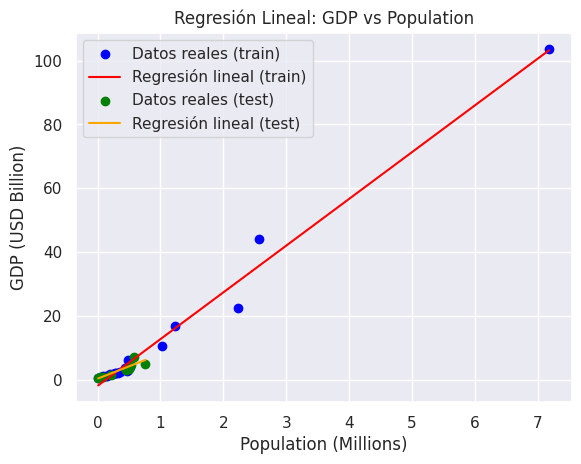

In [53]:
# Graficar los puntos y la línea de regresión para entrenamiento
plt.scatter(df_X, df_Y, color='blue', label='Datos reales (train)')
plt.plot(df_X_range, df_Y_pred, color='red', label='Regresión lineal (train)')

# Graficar los puntos y la línea de regresión para prueba
plt.scatter(dfa_X, dfa_Y, color='green', label='Datos reales (test)')
plt.plot(dfa_X_range, dfa_Y_pred, color='orange', label='Regresión lineal (test)')

# Etiquetas y título
plt.xlabel("Population (Millions)")
plt.ylabel("GDP (USD Billion)")
plt.title("Regresión Lineal: GDP vs Population")
plt.legend()
plt.grid(True)
plt.show()



#4.PCA

Cargar el data set de caras que está en la carpeta datos de la tarea 2 (ver notebook https://github.com/jdramirez/UCO_ML_AI/blob/master/src/notebook/PCA.ipynb):

Utiliza solo las caras de entrenamiento para los siguientes puntos:
1. Calcular la mean face. Que es la cara con el promedio de los pixeles y visualizarla.
2. Centrar los datos, utilizar PCA. ¿Cuántos componentes se deben utilizar para mantener el 95% de las características?. Crear una tabla para  mostrar las primeras 5 caras utilizando, la mean face + los datos
reconstruidos utilizando la primera componente, después con 3
componentes, después con las primeras 20 componentes, después con las componentes que explican el 95% de la varianza y por último con el numero de componentes que tiene el 99% de la varianza. ¿Qué se puede concluir de los resultados?
Cara
original
MeanFace + 1 comp
MeanFace + 3 comp
MeanFace + 10 comp
MeanFace + 95% comp

Utiliza los datos de testing. Y envía un archivo a kagle de los datos de testing con la primera componente. Recuerde que el testing no puede ser utilizado para aprender PCA.
https://www.kaggle.com/t/676b6edd04c64a1cbd83e7b6daf9b59b



In [9]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from urllib.request import urlretrieve
from google.colab import files
from sklearn.preprocessing import StandardScaler

def download_files():
    """Descarga y extrae las imágenes si no existen."""
    os.makedirs("data", exist_ok=True)
    path_tar = os.path.join("data", 'faces.zip')

    if not os.path.isfile(path_tar):
        urlretrieve(
            'http://courses.media.mit.edu/2002fall/mas622j/proj/faces/rawdata.zip',
            path_tar
        )

    dest_path = "data/faces"
    if not os.path.exists(dest_path):
        with zipfile.ZipFile(path_tar, 'r') as tar:
            tar.extractall(dest_path)


In [10]:
def cargar_imagenes_binarias(ruta, nombres):
    """Carga imágenes binarias en escala de grises (128x128 píxeles)."""
    imagenes, nombres_validos = [], []

    for nombre in nombres:
        ruta_completa = os.path.join(ruta, str(nombre))
        if os.path.isfile(ruta_completa):
            try:
                with open(ruta_completa, "rb") as f:
                    bytes_read = f.read()
                    if len(bytes_read) == 128 * 128:  # Validación de tamaño
                        img = Image.frombytes("L", (128, 128), bytes_read)
                        imagenes.append(np.array(img).flatten())
                        nombres_validos.append(nombre)
            except Exception as e:
                print(f"No se pudo cargar {nombre}: {e}")

    print(f"Cargadas {len(imagenes)} de {len(nombres)} imágenes.")
    return np.array(imagenes), nombres_validos

def mostrar_imagen(datos, titulo="Imagen Promedio"):
    """Muestra una imagen en escala de grises."""
    img = datos.reshape(128, 128)
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap="gray")
    plt.title(titulo, fontsize=14)
    plt.axis("off")
    plt.show()

def reconstruir_imagenes(pca, imagenes_centradas, mean_face, n_componentes):
    """Reconstruye imágenes a partir de un número dado de componentes principales."""
    proyeccion = pca.transform(imagenes_centradas)
    proyeccion[:, n_componentes:] = 0
    reconstruidas = pca.inverse_transform(proyeccion) + mean_face
    return np.clip(reconstruidas, 0, 255)

def visualizar_reconstrucciones(imagenes, pca, imagenes_centradas, mean_face, componentes):
    """Muestra reconstrucciones con diferentes cantidades de componentes principales."""
    fig, axes = plt.subplots(nrows=len(imagenes), ncols=len(componentes) + 1, figsize=(12, 8))

    for j, imagen in enumerate(imagenes):
        axes[j, 0].imshow(imagen.reshape(128, 128), cmap="gray")
        axes[j, 0].set_title("Original")
        axes[j, 0].axis("off")

        for i, comp in enumerate(componentes):
            reconstruida = reconstruir_imagenes(pca, imagenes_centradas[j:j+1], mean_face, comp)
            axes[j, i + 1].imshow(reconstruida.reshape(128, 128), cmap="gray")
            axes[j, i + 1].set_title(f"{comp} comp.")
            axes[j, i + 1].axis("off")

    plt.tight_layout()
    plt.show()

Cargadas 1299 de 1300 imágenes.


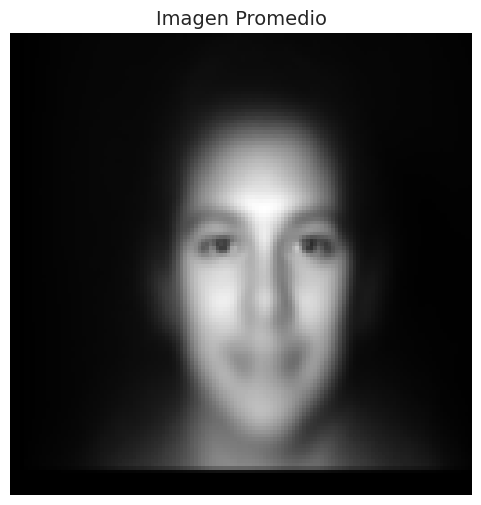

Número de componentes para 95% de varianza: 152
Número de componentes para 99% de varianza: 446


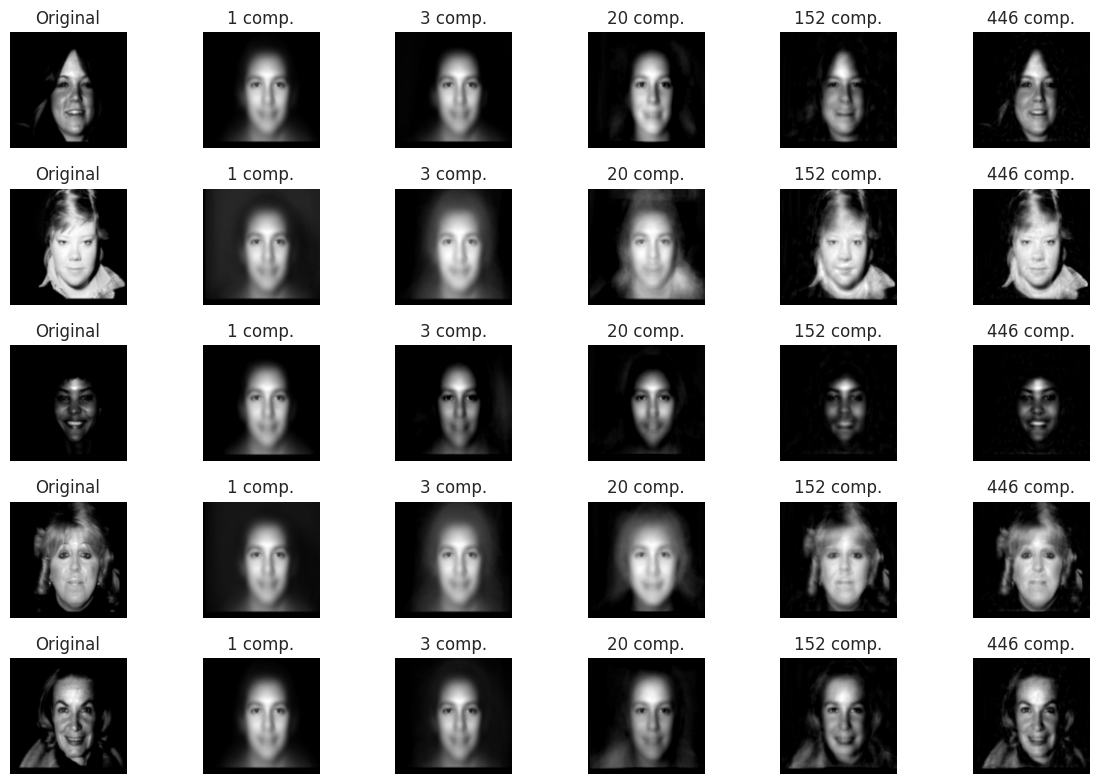

Cargadas 300 de 300 imágenes.
Archivo PCAJoseTobon.csv generado correctamente.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
download_files()
ruta_imagenes = "data/faces/rawdata"

# Cargar datos de entrenamiento y prueba
entrenamiento = [1855,4729,3954,2886,3168,4943,2288,2872,5059,2618,3365,1432,5092,4140,1600,4372,3157,2085,1264,
                4716,3533,3701,4524,1290,2415,2627,3391,2243,4988,5066,4386,2071,2875,2049,4944,4178,3953,2881,
                1638,1852,3739,4381,3998,2076,3396,2244,5061,2620,1899,1297,2412,3706,4523,1263,4711,3534,1607,
                4375,3150,2082,3362,1435,5095,4147,4986,5068,4388,2843,3991,2629,1890,4718,1864,4972,3965,3159,
                2616,2424,2040,3192,4185,5057,2272,2888,3166,1631,4343,1403,4171,2286,3354,4515,3730,3502,1255,
                4727,1609,3962,4975,4149,3708,1863,1897,1299,2844,3996,2078,3398,4981,3505,1252,4720,4512,3737,
                1404,4176,2281,3353,3161,1636,4344,4182,5050,2275,2047,3195,2423,2611,3763,4546,4774,3551,2483,
                4310,1662,3135,3909,3307,4122,1450,1696,2013,2221,3797,2645,4780,2477,4921,3338,3936,1239,1837,
                4579,2448,2810,5209,4787,2470,3790,2642,2226,5003,1691,2014,2828,3300,4125,4919,1457,4317,1665,
                3132,4773,3556,2484,3764,4541,2817,2219,1830,2689,3569,3931,4328,4926,1468,5035,1495,2210,2022,
                5207,2446,3594,4583,2674,3560,4745,1237,4577,1839,2680,3752,4113,1461,3336,3104,3938,4321,1653,
                3799,2479,1698,2821,3907,3309,4910,4548,1806,3103,4326,1654,4114,1466,4928,3331,4570,2687,3755,
                3567,4742,1230,4584,2673,2441,3593,2025,2819,5200,5032,1492,2217,3558,1801,1459,4917,4319,3900,
                2228,2826,4789,1298,1896,3399,4980,2079,2845,3997,4148,4974,1608,3963,3709,1862,2046,3194,4183,
                5051,2274,2610,2422,4513,3736,3504,4721,1253,3160,4345,1637,4177,1405,2280,3352,1865,4719,3158,
                3964,4973,4389,2842,3990,5069,4987,2628,1891,4170,1402,2287,3355,3167,2889,4342,1630,3503,4726,
                1254,4514,3731,2425,2617,4184,5056,2273,2041,3193,3952,2880,1639,4179,4945,1853,3738,2048,2874,
                4710,1262,3535,3707,4522,3363,5094,4146,1434,4374,1606,3151,2083,3397,2245,5060,4380,2077,3999,
                1296,2413,2621,1898,5058,2873,2619,4728,1854,4942,2289,3169,3955,2887,2626,1291,2414,4387,2070,
                3390,2242,5067,4989,4373,1601,3156,2084,3364,5093,4141,1433,3700,4525,4717,1265,3532,2440,3592,
                4585,2672,1493,5033,2216,2818,2024,5201,1467,4929,4115,3330,3102,1655,4327,3566,1231,4743,4571,
                2686,3754,2827,2229,4788,1800,3559,4318,3901,1458,4916,4576,1838,2681,3753,3561,1236,4744,3939,
                3105,1652,4320,1460,4112,3337,2023,5206,1494,5034,2211,4582,2675,2447,3595,3308,4911,3906,4549,
                1807,2478,3798,1699,2820,1664,4316,3133,3301,4918,1456,4124,3765,4540,4772,3557,2485,3791,2643,
                4786,2471,1690,2829,2015,2227,5002,3568,1831,2688,4927,1469,3930,4329,2218,2816,2220,5005,1697,
                2012,4781,2476,3796,2644,4775,3550,2482,3762,1809,4547,3306,1451,4123,1663,4311,3908,3134,2449,
                2811,5208,3937,4920,3339,1836,4578,1238,1944,4638,3079,2997,3845,4852,2399,2963,5148,2709,3274,
                4051,5183,1523,4263,1711,2194,3046,4607,1375,3422,3610,4435,1381,2504,2736,2352,3280,5177,4899,
                4297,2160,2158,2964,4069,4855,2990,3842,1729,1943,3628,4290,2167,3889,2355,3287,5170,2731,1988,
                1386,2503,3617,4432,4600,1372,3425,4264,1716,2193,3041,3273,5184,1524,5179,4897,4299,3880,2952,
                2738,1981,4609,1975,4863,3048,3874,2707,2535,3083,2151,5146,4094,2363,3077,2999,4252,1720,4060,
                1512,3245,2397,4404,3621,3413,4636,1344,1718,3873,4058,4864,3619,1972,1986,1388,2169,3887,2955,
                3289,4890,3414,4631,1343,4403,3626,4067,1515,3242,2390,3070,4255,1727,5141,4093,2364,3084,2156,
                2532,2700,3672,4457,1919,1317,4665,2592,3440,1773,4201,3818,3024,3216,1541,4033,1787,2102,2330,
                5115,2754,3686,4691,2566,4830,3229,3827,1328,4468,1926,2559,2901,4696,2561,2753,3681,2337,5112,
                1780,2939,2105,3211,1546,4808,4034,1774,4206,3023,1310,4662,2595,3447,3675,4450,2906,2308,1921,
                2798,3478,3820,4239,1579,4837,1584,5124,2301,2133,3485,2557,4492,2765,3471,1326,4654,1928,4466,
                3643,2791,1570,4002,3227,3829,3015,1742,4230,3688,2568,1789,2930,3816,3218,4801,1917,4459,1319,
                3012,1745,4237,4839,1577,4005,3220,4461,3644,2796,3476,1321,4653,4495,2762,3482,2550,2908,2134,
                1583,5123,2306,3449,1910,4806,1548,4208,3811,2339,2937,4698,1389,1987,3288,4891,3886,2954,2168,
                4865,4059,1719,3872,3618,1973,3085,2157,5140,4092,2365,2701,2533,4402,3627,3415,1342,4630,3071,
                1726,4254,1514,4066,3243,2391,1974,4608,3875,3049,4862,4298,3881,2953,4896,5178,2739,1980,1513,
                4061,3244,2396,2998,3076,1721,4253,3412,1345,4637,4405,3620,2534,2706,5147,4095,2362,3082,2150,
                2991,3843,1728,4854,4068,1942,3629,2965,2159,1373,4601,3424,3616,4433,3272,1525,4057,5185,1717,
                4265,2192,3040,2354,3286,5171,4291,3888,2166,1387,2502,2730,1989,5149,2962,2708,4639,1945,4853,
                2398,2996,3844,3078,2737,1380,2505,4296,2161,2353,3281,4898,5176,1710,4262,2195,3047,3275,1522,
                4050,5182,3611,4434,1374,4606,3423,3483,2551,4494,2763,5122,1582,2307,2135,2909,4004,4838,1576,
                3221,3013,4236,1744,3477,4652,1320,4460,3645,2797,2936,2338,4699,1911,3448,4209,3810,4807,1549,
                1929,4467,3642,2790,3470,4655,1327,3014,3828,4231,1743,4003,1571,3226,2132,5125,1585,2300,4493,
                2764,3484,2556,3219,4800,3817,1318,1916,4458,2569,3689,1788,2931,4207,1775,3022,3210,4035,1547,
                4809,3674,4451,4663,1311,2594,3446,2752,3680,4697,2560,1781,2104,2938,2336,5113,3479,1920,2799,
                1578,4836,3821,4238,2309,2907,2331,5114,1786,2103,4690,2567,2755,3687,4664,1316,2593,3441,3673,
                4456,1918,3217,4032,1540,4200,1772,3025,3819,2558,2900,3826,4831,3228,4469,1927,1329,5109,2922,
                2748,4679,1905,4813,3038,3804,2777,4480,3497,2545,2121,2313,5136,1596,4222,1750,3007,3235,4010,
                1562,3651,2783,4474,4646,1334,3463,3803,1768,4028,4814,1902,3669,2589,2119,2925,4641,1333,3464,
                3656,2784,4473,3232,4017,1565,4225,1757,3000,2314,5131,1591,2126,3490,2542,2770,4487,1934,4648,
                3009,3835,4822,2913,5138,1598,2779,3499,4021,1553,3204,3036,4213,1761,2580,3452,4677,1305,4445,
                3660,2574,4683,2746,3694,5107,2322,2110,1795,4489,2128,2914,4019,4825,1759,3832,3658,1933,2117,
                1792,5100,2325,2741,3693,2573,4684,4442,3667,2587,3455,4670,1302,3031,4214,1766,4026,1554,3203,
                2371,5154,4086,3091,2143,2527,2715,1356,4624,3401,3633,4416,1958,3257,2385,1500,4072,1732,4240,
                3859,3065,1993,2518,3892,2940,4885,3866,2188,4871,3268,4429,1967,1369,1735,4247,3062,3250,2382,
                1507,4849,4075,3634,4411,1351,4623,3406,2712,2520,2978,3096,2144,2376,5153,4081,3439,1960,1538,
                4876,5198,3861,4278,4882,2349,3895,2947,1994,1969,4427,3602,3430,1367,4615,3868,2186,3054,1703,
                4271,1531,4043,5191,3266,2172,4285,5165,2340,3292,2724,2516,1393,3259,4840,2985,3857,1358,1956,
                4418,2529,4088,2971,2511,1394,2723,5162,2347,3295,2949,2175,4282,4878,1536,4044,5196,3261,2181,
                3053,1704,4276,3437,1360,4612,4420,3605,2976,3098,2378,1951,3408,4249,2982,3850,4847,1509,1758,
                3833,4824,4018,3659,1932,4488,2915,2129,2586,3454,1303,4671,4443,3666,1555,4027,3202,3030,1767,
                4215,5101,2324,2116,1793,2572,4685,2740,3692,1599,5139,2912,3498,2778,4649,1935,4823,3834,3008,
                2747,3695,2575,4682,2111,1794,5106,2323]  # Lista completa
prueba = [3037,1760,4212,1552,4020,3205,4444,3661,2581,3453,1304,4676,2924,2118,4815,4029,3802,1769,2588,
              1903,3668,2127,2315,1590,5130,2771,4486,3491,2543,3657,2785,4472,1332,4640,3465,1756,4224,3001,3233,
              1564,4016,1904,4678,3805,3039,4812,2923,5108,2749,3234,1563,4011,1751,4223,3006,1335,4647,3462,3650,
              2782,4475,3496,2544,2776,4481,2312,1597,5137,2120,2180,3052,4277,1705,4045,5197,4879,1537,3260,4421,
              3604,3436,4613,1361,2722,2510,1395,2174,2948,4283,5163,2346,3294,3409,1950,4846,1508,4248,2983,3851,
              2379,3099,2977,5164,2341,3293,2173,4284,2517,1392,2725,3431,4614,1366,1968,4426,3603,4042,5190,1530,
              3267,2187,3055,3869,4270,1702,2528,2970,4089,2984,3856,3258,4841,1957,4419,1359,2521,2713,2377,5152,
              4080,3097,2145,2979,3251,2383,4074,1506,4848,4246,1734,3063,4622,1350,3407,3635,4410,3894,2946,4883,
              2348,1995,1961,3438,3860,4279,5199,1539,4877,3632,4417,1959,4625,1357,3400,4241,1733,3064,3858,3256,
              2384,4073,1501,3090,2142,2370,5155,4087,2714,2526,4870,3269,2189,3867,1368,4428,1966,2519,1992,4884,
              3893,2941,5018,2833,2659,4768,1814,4902,3915,3129,2666,4591,2454,3586,5215,2030,2202,1487,5027,1641,
              4333,3116,3324,1473,4101,2692,3740,4565,1225,4757,3572,3912,1679,4905,4139,1813,3778,2498,2834,2008,
              4750,3575,2695,3747,4562,3323,1474,4106,1646,4334,3111,2205,1480,5020,5212,2037,2453,3581,2661,4596,
              1825,4759,3924,3118,4933,2802,1489,5029,2668,3588,1442,4130,3315,3127,1670,4302,3543,2491,4766,4554,
              3771,2465,4792,3785,2657,5016,2233,2001,1684,4598,2805,2039,4934,4108,1648,3923,3749,1822,2006,1683,
              5011]  # Lista completa

imagenes, nombres_validos_train = cargar_imagenes_binarias(ruta_imagenes, entrenamiento)

# Calcular la cara promedio y centrar datos
if len(imagenes) > 0:
    mean_face = np.mean(imagenes, axis=0)
    imagenes_centradas = imagenes - mean_face

    scaler = StandardScaler()
    imagenes_normalizadas = scaler.fit_transform(imagenes_centradas)
    mostrar_imagen(mean_face, titulo="Imagen Promedio")

    # Aplicar PCA con whitening
    pca = PCA(whiten=True)
    pca.fit(imagenes_normalizadas)
    varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)


    # Componentes necesarias para 95% y 99% de varianza
    n_95 = np.argmax(varianza_acumulada >= 0.95) + 1
    n_99 = np.argmax(varianza_acumulada >= 0.99) + 1

    print(f"Número de componentes para 95% de varianza: {n_95}")
    print(f"Número de componentes para 99% de varianza: {n_99}")

    # Visualizar reconstrucciones
    visualizar_reconstrucciones(imagenes[:5], pca, imagenes_centradas, mean_face, [1, 3, 20, n_95, n_99])

    # Cargar imágenes de prueba y aplicar PCA
    Te, nombres_validos_test = cargar_imagenes_binarias(ruta_imagenes, prueba)
    if len(Te) > 0:
        Te_normalizadas = scaler.transform(Te - mean_face)
        Te_proj = pca.transform(Te_normalizadas)

        # Guardar en CSV
        output = pd.DataFrame({'id': nombres_validos_test, 'label': Te_proj[:, 0]})
        output.to_csv('PCAJoseTobon.csv', index=False)
        print("Archivo PCAJoseTobon.csv generado correctamente.")
        # Descargar el archivo
        files.download("PCAJoseTobon.csv")


###Conclusiones

* El análisis muestra que es posible reducir la dimensionalidad de las imágenes significativamente sin perder demasiada información. Para retener el 95% de la varianza, se requieren 152 componentes, mientras que para el 99%, se necesitan 446 componentes, lo que sugiere que la información esencial del rostro está contenida en una fracción de los datos originales.


* La reconstrucción con solo 1 o 3 componentes principales no es suficiente para distinguir claramente los rostros, pero a partir de 20 componentes, la forma general empieza a ser reconocible. Con 152 componentes, las imágenes reconstruidas son casi idénticas a las originales, lo que demuestra que el PCA es una técnica efectiva para la compresión con mínima distorsión visual.


* Aunque utilizar 446 componentes ofrece una reconstrucción casi perfecta, la diferencia visual con 152 componentes es mínima. Esto indica que en aplicaciones donde el almacenamiento o el procesamiento computacional es un factor clave, se puede optar por un número menor de componentes sin afectar significativamente la calidad de la imagen.

* Este enfoque es útil en tareas como reconocimiento facial, clasificación de imágenes y reducción de carga computacional en modelos de machine learning. Al reducir la cantidad de datos sin perder información relevante, se optimizan los cálculos y se mejora el rendimiento de los sistemas de reconocimiento de patrones.

#5 Exploración de datos#
Utilizando el dataset del amazon data/amazon_products.csv crear: Utilizar la librería de plotly.

5.1. Distribución de cada variables:

5.1.1. Para las variables categóricas un gráfico de barras. Categoría numero de observaciones.

5.1.2. Para las variables numéricas crear histogramas. Listar los productos que están más lejos de 5 estándares de desviación, y
serían considerados outliers. Hacer test de si es una distribución normal o no.

5.2. Gráfico de la relación de cada variable con respecto al sales_volume (convertir a numero):

5.2.1. Variables categóricas debes crear un boxplot. Explique cómo interpreta el gráfico

5.2.2. Variables numéricas vas a crear un scatter plot.Explique cómo interpreta el gráfico

5.3. Matriz de correlación.

5.3.1. Cree la matriz de correlación, cuales son las variables más importantes para explicar la variabilidad de las sales_volume. Explique por qué el coeficiente es negativo o positivo.

5.3.2. Cree las dummy variables para todas las variables categóricas y genere la matriz de correlación nuevamente. ¿Cuál es el valor de variable categórica con mayor correlación?

5.3.3. Utilizar python para imputar los valores nulos con la media. Después dividir los datos en train y test. Por ultimo hacer una regresión entre x que es product_num_ratings y y  
product_star_rating qué es la calificación. Cual es el coeficiente b1 y b0. Describir resultados.

In [12]:
! pip install numpy pandas plotly scipy pysqlite3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pysqlite3: filename=pysqlite3-0.5.4-cp311-cp311-linux_x86_64.whl size=159234 sha256=2f4795909b634290b12b99df7ab66d460267b546b7df3737789eaab992d9de7c
  Stored in directory: /root/.cache/pip/wheels/83/05/4e/8fb9d7378ff72e4fd02b69df7a6052c34d33cea2a0231ca232
Successfully built pysqlite3


In [47]:
import numpy as np
import os
import pandas as pd
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import tarfile
import zipfile
from scipy.io import loadmat
from urllib.request import urlretrieve
from os.path import isfile, isdir
import plotly.express as px
import re
from scipy.stats import shapiro
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [22]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Permitir la carga de datos desde una fuente configurable
def load_data(filepath):
    if os.path.exists(filepath):
        return pd.read_csv(filepath)
    else:
        raise FileNotFoundError(f"El archivo {filepath} no se encuentra.")
df = load_data("sample_data/amazon_product.csv")

In [ ]:
df.head(20)

,Unnamed: 0,asin,product_title,product_price,product_original_price,currency,product_star_rating,product_num_ratings,product_url,product_photo,product_num_offers,product_minimum_offer_price,is_best_seller,is_amazon_choice,is_prime,climate_pledge_friendly,sales_volume,delivery,has_variations,product_availability,unit_price,unit_count
0,0,B0BQ118F2T,Moto G Play 2023 3-Day Battery Unlocked Made f...,99.99,169.99,USD,4.0,2929,https://www.amazon.com/dp/B0BQ118F2T,https://m.media-amazon.com/images/I/61K1Fz5Lxv...,10,64.89,False,False,True,False,6000.0,"FREE delivery Tue, Aug 6",True,NaN,0.59,3.0
1,1,B0CTD47P22,"SAMSUNG Galaxy A15 5G (SM-156M/DSN), 128GB 6GB...",149.74,158.00,USD,4.2,135,https://www.amazon.com/dp/B0CTD47P22,https://m.media-amazon.com/images/I/51QhB2CfqS...,8,145.87,False,False,True,False,3000.0,"FREE delivery Wed, Aug 7 Only 7 left in stock ...",False,Only 7 left in stock - order soon.,0.59,3.0
2,2,B0CHH6X6H2,Total by Verizon | Samsung Galaxy A03s | Locke...,49.88,56.95,USD,3.9,205,https://www.amazon.com/dp/B0CHH6X6H2,https://m.media-amazon.com/images/I/812woqv69C...,1,49.88,False,False,True,False,2000.0,"FREE delivery Tue, Aug 6",False,NaN,0.59,3.0
3,3,B0BZ9XNBRB,Google Pixel 7a - Unlocked Android Cell Phone ...,335.00,499.00,USD,4.3,2248,https://www.amazon.com/dp/B0BZ9XNBRB,https://m.media-amazon.com/images/I/61r7cCpQPl...,30,289.99,False,False,False,False,10000.0,FREE delivery Aug 6 - 8,True,NaN,0.59,3.0
4,4,B0CN1QSH8Q,"SAMSUNG Galaxy A15 5G A Series Cell Phone, 128...",199.99,56.95,USD,4.1,423,https://www.amazon.com/dp/B0CN1QSH8Q,https://m.media-amazon.com/images/I/61s0ZzwzSC...,2,150.09,False,False,True,True,3000.0,"FREE delivery Tue, Aug 6",True,NaN,0.59,3.0
5,5,B0CSB22F9C,"Samsung Galaxy A15 (SM-155M/DSN), 128GB 6GB RA...",129.99,137.65,USD,4.2,578,https://www.amazon.com/dp/B0CSB22F9C,https://m.media-amazon.com/images/I/51rp0nqaPo...,13,128.12,False,False,True,False,3000.0,"FREE delivery Tue, Aug 6",False,NaN,0.59,3.0
6,6,B0CV4NQYFP,"SAMSUNG Galaxy A35 5G A Series Cell Phone, 128...",349.99,399.99,USD,4.4,109,https://www.amazon.com/dp/B0CV4NQYFP,https://m.media-amazon.com/images/I/71OznGGxhc...,2,267.01,False,False,True,True,3000.0,"FREE delivery Tue, Aug 6 Or fastest delivery M...",True,NaN,0.59,3.0
7,7,B0CHH1N9VY,TracFone | Motorola Moto g Pure | Locked | 32G...,49.39,56.95,USD,4.2,2771,https://www.amazon.com/dp/B0CHH1N9VY,https://m.media-amazon.com/images/I/71zGrrAe5N...,1,49.39,False,False,True,False,500.0,"FREE delivery Tue, Aug 6 Or fastest delivery M...",False,NaN,0.59,3.0
8,8,B0BLZN9NDG,"SAMSUNG,Galaxy A04e (SM-A042M/DS) Dual SIM 32G...",87.10,105.00,USD,3.9,613,https://www.amazon.com/dp/B0BLZN9NDG,https://m.media-amazon.com/images/I/71O2YkTlq-...,10,81.18,False,False,True,False,1000.0,"FREE delivery Tue, Aug 6",True,NaN,0.59,3.0
9,9,B0CP6DDN1H,Moto G Play | 2024 | Unlocked | Made for US 4/...,129.99,149.99,USD,4.1,94,https://www.amazon.com/dp/B0CP6DDN1H,https://m.media-amazon.com/images/I/61xk4XNRkt...,4,94.99,False,False,True,False,1000.0,"FREE delivery Tue, Aug 6 Or fastest delivery M...",False,NaN,0.59,3.0


In [26]:
# Variables categóricas y numéricas
numerical_cols = ["product_price","product_original_price","product_star_rating","product_num_ratings","product_num_offers","product_minimum_offer_price","sales_volume","unit_price","unit_count"]
categorical_cols = ["currency","is_best_seller","is_amazon_choice","is_prime","climate_pledge_friendly","has_variations"]

def sanitize_sales_volume(value):
    match = re.search(r'(\d+(?:\.\d+)?)(K?)\+?', str(value))
    if match:
        num = float(match.group(1))
        if match.group(2) == "K":
            num *= 1000
        return num
    return np.nan

df["sales_volume"] = df["sales_volume"].apply(sanitize_sales_volume)

# Convert currency columns to numeric before filling NaN
cols_to_clean = ["product_price", "product_original_price", "product_minimum_offer_price", "unit_price"]
for col in cols_to_clean:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce')

# Now fill NaN values in numerical columns with the median of those columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

In [27]:
df.head(20)

,Unnamed: 0,asin,product_title,product_price,product_original_price,currency,product_star_rating,product_num_ratings,product_url,product_photo,product_num_offers,product_minimum_offer_price,is_best_seller,is_amazon_choice,is_prime,climate_pledge_friendly,sales_volume,delivery,has_variations,product_availability,unit_price,unit_count
0,0,B0BQ118F2T,Moto G Play 2023 3-Day Battery Unlocked Made f...,99.99,169.99,USD,4.0,2929,https://www.amazon.com/dp/B0BQ118F2T,https://m.media-amazon.com/images/I/61K1Fz5Lxv...,10,64.89,False,False,True,False,6000.0,"FREE delivery Tue, Aug 6",True,NaN,0.59,3.0
1,1,B0CTD47P22,"SAMSUNG Galaxy A15 5G (SM-156M/DSN), 128GB 6GB...",149.74,158.00,USD,4.2,135,https://www.amazon.com/dp/B0CTD47P22,https://m.media-amazon.com/images/I/51QhB2CfqS...,8,145.87,False,False,True,False,3000.0,"FREE delivery Wed, Aug 7 Only 7 left in stock ...",False,Only 7 left in stock - order soon.,0.59,3.0
2,2,B0CHH6X6H2,Total by Verizon | Samsung Galaxy A03s | Locke...,49.88,56.95,USD,3.9,205,https://www.amazon.com/dp/B0CHH6X6H2,https://m.media-amazon.com/images/I/812woqv69C...,1,49.88,False,False,True,False,2000.0,"FREE delivery Tue, Aug 6",False,NaN,0.59,3.0
3,3,B0BZ9XNBRB,Google Pixel 7a - Unlocked Android Cell Phone ...,335.00,499.00,USD,4.3,2248,https://www.amazon.com/dp/B0BZ9XNBRB,https://m.media-amazon.com/images/I/61r7cCpQPl...,30,289.99,False,False,False,False,10000.0,FREE delivery Aug 6 - 8,True,NaN,0.59,3.0
4,4,B0CN1QSH8Q,"SAMSUNG Galaxy A15 5G A Series Cell Phone, 128...",199.99,56.95,USD,4.1,423,https://www.amazon.com/dp/B0CN1QSH8Q,https://m.media-amazon.com/images/I/61s0ZzwzSC...,2,150.09,False,False,True,True,3000.0,"FREE delivery Tue, Aug 6",True,NaN,0.59,3.0
5,5,B0CSB22F9C,"Samsung Galaxy A15 (SM-155M/DSN), 128GB 6GB RA...",129.99,137.65,USD,4.2,578,https://www.amazon.com/dp/B0CSB22F9C,https://m.media-amazon.com/images/I/51rp0nqaPo...,13,128.12,False,False,True,False,3000.0,"FREE delivery Tue, Aug 6",False,NaN,0.59,3.0
6,6,B0CV4NQYFP,"SAMSUNG Galaxy A35 5G A Series Cell Phone, 128...",349.99,399.99,USD,4.4,109,https://www.amazon.com/dp/B0CV4NQYFP,https://m.media-amazon.com/images/I/71OznGGxhc...,2,267.01,False,False,True,True,3000.0,"FREE delivery Tue, Aug 6 Or fastest delivery M...",True,NaN,0.59,3.0
7,7,B0CHH1N9VY,TracFone | Motorola Moto g Pure | Locked | 32G...,49.39,56.95,USD,4.2,2771,https://www.amazon.com/dp/B0CHH1N9VY,https://m.media-amazon.com/images/I/71zGrrAe5N...,1,49.39,False,False,True,False,500.0,"FREE delivery Tue, Aug 6 Or fastest delivery M...",False,NaN,0.59,3.0
8,8,B0BLZN9NDG,"SAMSUNG,Galaxy A04e (SM-A042M/DS) Dual SIM 32G...",87.10,105.00,USD,3.9,613,https://www.amazon.com/dp/B0BLZN9NDG,https://m.media-amazon.com/images/I/71O2YkTlq-...,10,81.18,False,False,True,False,1000.0,"FREE delivery Tue, Aug 6",True,NaN,0.59,3.0
9,9,B0CP6DDN1H,Moto G Play | 2024 | Unlocked | Made for US 4/...,129.99,149.99,USD,4.1,94,https://www.amazon.com/dp/B0CP6DDN1H,https://m.media-amazon.com/images/I/61xk4XNRkt...,4,94.99,False,False,True,False,1000.0,"FREE delivery Tue, Aug 6 Or fastest delivery M...",False,NaN,0.59,3.0


In [29]:
# Gráfico de barras para variables categóricas con mejoras visuales
for col in categorical_cols:
    #  Pass the name of the index column for the x argument
    # This column will be named after your loop variable 'col' after reset_index()
    fig = px.bar(df[col].value_counts().reset_index(), x=col, y='count',
                 labels={'index': col, 'count': 'Cantidad'}, title=f"Distribución de {col}")
    fig.update_layout(xaxis_title=col, yaxis_title="Cantidad", template="plotly_dark")
    fig.show()

La exploración de los datos revela una distribución desigual en varias variables categóricas y numéricas. Se observó que ciertas categorías, como is_best_seller, presentan una gran diferencia en la cantidad de productos etiquetados como "true" o "false", lo que sugiere un sesgo en la representación de los datos. Además, el análisis de correlación mostró que variables como unit_count y unit_price tienen una fuerte relación con el sales_volume, mientras que otras, como product_num_offers, presentan una relación negativa. Esto indica que la cantidad de unidades y el precio por unidad son factores determinantes en el volumen de ventas, mientras que un mayor número de ofertas podría estar asociado con productos menos populares o con mayor competencia.

En términos de modelado, la regresión lineal aplicada mostró un desempeño aceptable en la predicción de product_star_rating, aunque la necesidad de imputación de valores faltantes y la normalización de los datos sugiere que la calidad y distribución de las variables podrían mejorarse. En general, los resultados indican que es fundamental abordar la distribución desigual y el preprocesamiento de los datos para mejorar la precisión de los modelos predictivos y la interpretación de las tendencias en el mercado de productos.

In [33]:
# Histograma de variables numéricas
for col in numerical_cols:
    fig = px.histogram(df, x=col, title=f"Histograma de {col}", nbins=50, template="plotly_dark")
    fig.show()


El análisis de los datos revela una distribución desigual en diversas variables clave. Por ejemplo, a variable is_best_seller muestra que la mayoría de los productos no son best sellers, lo que indica que solo una minoría logra un alto nivel de ventas. De manera similar, la distribución del product_price es asimétrica, con una mayor concentración de productos en rangos de precio más bajos y una disminución significativa a medida que el precio aumenta.

En cuanto a la correlación de las variables con sales_volume, factores como unit_count y unit_price tienen un impacto positivo considerable, mientras que otras variables relacionadas con el precio, como product_original_price y product_minimum_offer_price, presentan coeficientes negativos, sugiriendo que precios más altos pueden afectar negativamente el volumen de ventas.

Estos hallazgos sugieren que el mercado se concentra en productos accesibles en precio y en aquellos con mayor disponibilidad de unidades, mientras que los productos más costosos tienden a tener menor demanda. Esta información es clave para estrategias de fijación de precios y gestión de inventarios en plataformas de comercio electrónico.

In [36]:
# Identificar outliers usando el método del rango intercuartil (IQR)
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[col] < lower_bound) | (data[col] > upper_bound)]

outlier_data = []
for col in numerical_cols:
    outliers = detect_outliers_iqr(df, col)
    if not outliers.empty:
        for index, row in outliers.iterrows():
            outlier_data.append([col, index, row[col]])

outlier_df = pd.DataFrame(outlier_data, columns=["Variable", "Índice", "Valor"])
print("Outliers detectados:")
print(outlier_df.to_markdown(index=False))

Outliers detectados:
| Variable                    |   Índice |            Valor |
|:----------------------------|---------:|-----------------:|
| product_price               |        3 |    335           |
| product_price               |        4 |    199.99        |
| product_price               |        6 |    349.99        |
| product_price               |       13 |    499           |
| product_price               |       14 |    199.99        |
| product_price               |       38 |    179.99        |
| product_original_price      |        0 |    169.99        |
| product_original_price      |        1 |    158           |
| product_original_price      |        3 |    499           |
| product_original_price      |        5 |    137.65        |
| product_original_price      |        6 |    399.99        |
| product_original_price      |        8 |    105           |
| product_original_price      |        9 |    149.99        |
| product_original_price      |       10 |     87

In [39]:
# Test de normalidad
for col in numerical_cols:
    stat, p = shapiro(df[col].dropna())
    print(f"Test de Shapiro-Wilk para {col}: p-value = {p}")
    print("  -> No es normal\n" if p < 0.05 else "  -> Normal\n")

Test de Shapiro-Wilk para product_price: p-value = 1.5730304224688095e-11
  -> No es normal

Test de Shapiro-Wilk para product_original_price: p-value = 1.2540185592319635e-13
  -> No es normal

Test de Shapiro-Wilk para product_star_rating: p-value = 5.005375676000724e-09
  -> No es normal

Test de Shapiro-Wilk para product_num_ratings: p-value = 4.928942717743817e-15
  -> No es normal

Test de Shapiro-Wilk para product_num_offers: p-value = 8.13206839911081e-13
  -> No es normal

Test de Shapiro-Wilk para product_minimum_offer_price: p-value = 4.5808919809974e-11
  -> No es normal

Test de Shapiro-Wilk para sales_volume: p-value = 2.6942253346042524e-14
  -> No es normal

Test de Shapiro-Wilk para unit_price: p-value = 1.0923110535791001e-16
  -> No es normal

Test de Shapiro-Wilk para unit_count: p-value = 1.7910525067964745e-17
  -> No es normal



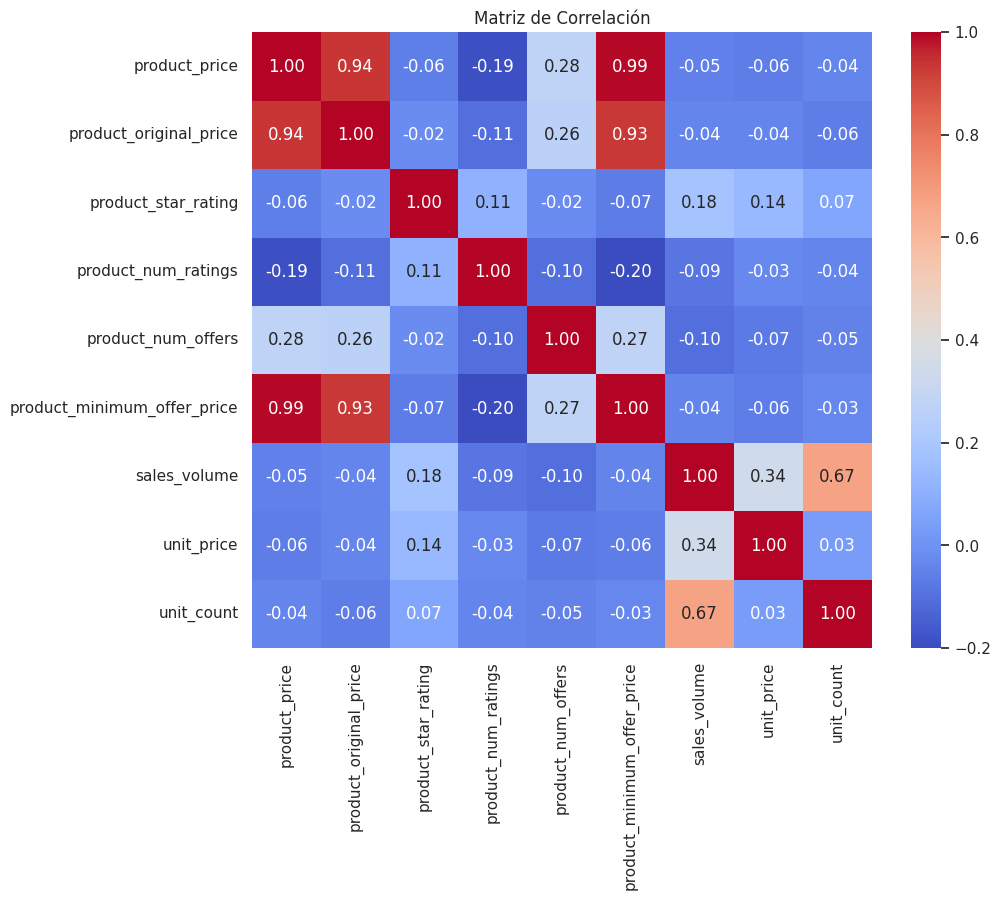

Variables más importantes para sales_volume:
unit_count                     0.671546
unit_price                     0.340355
product_star_rating            0.183401
product_original_price        -0.040107
product_minimum_offer_price   -0.043286
product_price                 -0.052581
product_num_ratings           -0.087357
product_num_offers            -0.104351
Name: sales_volume, dtype: float64


In [41]:
# Matriz de correlación
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlación")
plt.show()
correlation_with_sales = correlation_matrix["sales_volume"].drop("sales_volume").sort_values(ascending=False)
print("Variables más importantes para sales_volume:")
print(correlation_with_sales)

* Coeficientes positivos: Variables como unit_count (0.6715) y unit_price (0.3404) tienen un impacto positivo en las ventas, lo que sugiere que productos con más unidades o precios más altos tienden a venderse más.

* Coeficientes negativos: Variables como product_price (-0.0526) y product_num_ratings (-0.0874) tienen una relación inversa con sales_volume, lo que indica que precios elevados o demasiadas calificaciones pueden reducir el volumen de ventas.

* Variable más importante: unit_count es la que más influye en las ventas, indicando que los productos con mayor cantidad de unidades disponibles son los más vendidos.

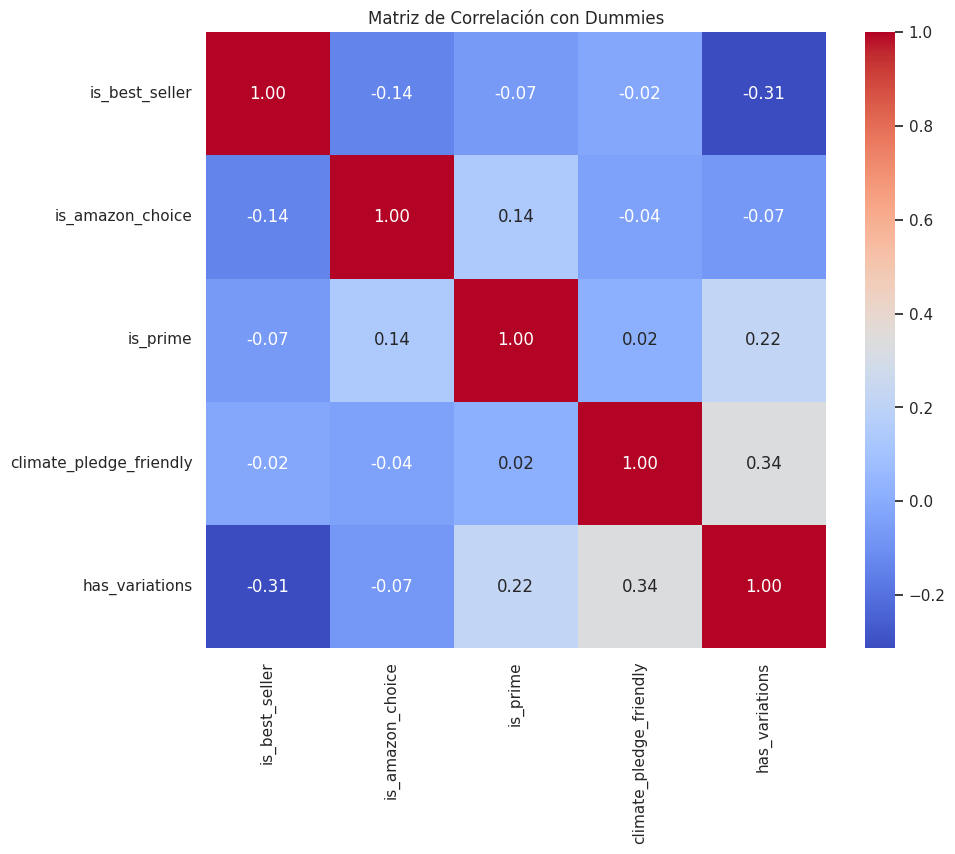

In [42]:
# Crear variables dummy
df_dummies = pd.get_dummies(df[categorical_cols].drop(columns=["currency"]))
correlation_matrix_dummies = df_dummies.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_dummies, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de Correlación con Dummies")
plt.show()


##¿Cuál es el valor de variable categórica con mayor correlación?
En la matriz de correlación mostrada en la imagen, la variable categórica con la mayor correlación es "has_variations", con un valor de 0.34 en relación con "climate_pledge_friendly". Esto sugiere una relación moderada entre estos atributos, lo que podría indicar que los productos con múltiples variaciones tienen mayor probabilidad de estar etiquetados como "climate_pledge_friendly".

In [48]:
# Assuming 'df' is your DataFrame and 'product_num_ratings' and 'product_star_rating' are your columns
X = df[['product_num_ratings']]  # Select the 'product_num_ratings' column for X
y = df['product_star_rating']  # Select the 'product_star_rating' column for y

# Imputar valores nulos con la media
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)
y = imputer.fit_transform(y.values.reshape(-1, 1)).ravel() # Reshape y to a 2D array before imputation

# Estandarizar los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir en train y test con validación cruzada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión
model = LinearRegression()
scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Desempeño del modelo con validación cruzada: {scores.mean():.4f} ± {scores.std():.4f}")

model.fit(X_train, y_train)

# Obtener coeficientes
b0 = model.intercept_
b1 = model.coef_

print(f"Coeficiente b0 (intercepto): {b0:.4f}")
print(f"Coeficientes b1 (pendientes): {b1}")

Desempeño del modelo con validación cruzada: -0.3068 ± 0.3308
Coeficiente b0 (intercepto): 4.2957
Coeficientes b1 (pendientes): [0.03848459]


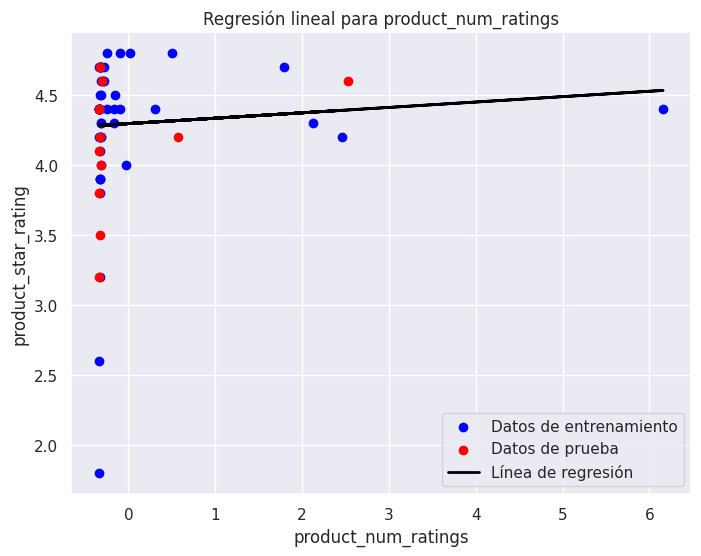

In [50]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], y_train, color='blue', label='Datos de entrenamiento')
plt.scatter(X_test[:, 0], y_test, color='red', label='Datos de prueba')
plt.plot(X_train[:, 0], model.predict(X_train), color='black', linewidth=2, label='Línea de regresión')
plt.xlabel('product_num_ratings')  # Changed to the actual column name
plt.ylabel("product_star_rating")
plt.title("Regresión lineal para product_num_ratings")  # Changed to the actual column name
plt.legend()
plt.show()

Estos valores indican que el product_star_rating tiene una relación muy débil con la variable predictora elegida. Además, el desempeño del modelo con validación cruzada es negativo (-0.3068 ± 0.3308), lo que sugiere que no está generalizando bien y podría no ser útil para predicciones.

###Conclusiones y mejoras:
* Baja influencia de las variables: La pendiente cercana a 0 indica que las variables elegidas apenas afectan el product_star_rating.

* Revisión de la correlación: Es recomendable elegir variables con mayor correlación para mejorar la predicción.

* Probar modelos más avanzados: Árboles de decisión o regresión polinómica pueden captar mejor patrones no lineales.